In [22]:
import json
import numpy as np

# helper to load the Kindle reviews JSON file. Returns a list of review dicts.
def load_reviews(path):
    reviews = []
    with open(path, 'r') as f:
        for line in f:
            reviews.append(json.loads(line))
    return reviews

# helper to groups reviews by user. Returns dict: userID -> list of (asin, rating).
def create_review_dict(reviews):
    user_reviews = {}
    for r in reviews:
        uid = r['reviewerID']
        user_reviews.setdefault(uid, []).append((r['asin'], int(r['overall'])))
    return user_reviews

# build user-item matrix x and a matrix of ratings for LOO >=3 threshold
# x is also thresholded where if rating is above 3, corresponding value is rating-1/4
# ratings matrix just holds the ratings (1-5) of reviews
def create_user_item_matrices(user_reviews, rating_weight_map=None):
    # build id maps
    users = list(user_reviews.keys())
    items = {asin for lst in user_reviews.values() for asin,_ in lst}
    user2id = {u:i for i,u in enumerate(users)}
    item2id = {asin:i for i,asin in enumerate(items)}
    num_users, num_items = len(users), len(items)

    # allocate
    x_real = np.zeros((num_users, num_items), dtype=np.float16)
    ratings_matrix = np.zeros((num_users, num_items), dtype=np.int8)

    for u, lst in user_reviews.items():
        ui = user2id[u]
        for asin, r in lst:
            ii = item2id[asin]
            ratings_matrix[ui, ii] = r
            if r >= 3:
                x_real[ui, ii] = np.float16((r - 1) / 4.0)
            # else remains 0.0

    return x_real, ratings_matrix, user2id, item2id


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, num_items: int, hidden_dim1: int = 600, hidden_dim2: int = 300, latent_dim: int = 100):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_items, hidden_dim1),
            nn.LayerNorm(hidden_dim1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LayerNorm(hidden_dim2),
            nn.ReLU(inplace=True),
        )
        self.fc_mu     = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.LayerNorm(hidden_dim2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.LayerNorm(hidden_dim1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim1, num_items),
        )

    def encode(self, x: torch.Tensor):
        h = self.encoder(x)
        mu      = self.fc_mu(h)
        logvar  = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor):
        logits = self.decoder(z)
        return logits

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar


Loading review data…
Users: 68223, Items: 61934, Interactions: 925471
Test hold-outs: 68155, Val hold-outs: 67951
Train batches: 67
Ep1/200 | ELBO=113.421 | RecLoss=112.987 | KLLoss=4.335 | Train 8.6s | Val 154.7s | Recall@10=0.000280 | Prec@10=0.000028 | NDCG@10=0.000000
Ep2/200 | ELBO=112.480 | Train 8.6s
Ep3/200 | ELBO=111.489 | Train 8.7s
Ep4/200 | ELBO=110.423 | Train 8.5s
Ep5/200 | ELBO=109.273 | RecLoss=109.154 | KLLoss=0.238 | Train 8.5s | Val 153.6s | Recall@10=0.006048 | Prec@10=0.000605 | NDCG@10=0.000000
Ep6/200 | ELBO=108.426 | Train 8.6s
Ep7/200 | ELBO=108.120 | Train 8.7s
Ep8/200 | ELBO=108.019 | Train 8.5s
Ep9/200 | ELBO=107.644 | Train 8.4s
Ep10/200 | ELBO=106.610 | RecLoss=106.197 | KLLoss=0.413 | Train 8.5s | Val 152.6s | Recall@10=0.008256 | Prec@10=0.000826 | NDCG@10=0.000000
Ep11/200 | ELBO=105.746 | Train 8.5s
Ep12/200 | ELBO=105.051 | Train 8.7s
Ep13/200 | ELBO=104.174 | Train 8.7s
Ep14/200 | ELBO=103.075 | Train 8.5s
Ep15/200 | ELBO=102.025 | RecLoss=100.484 | 

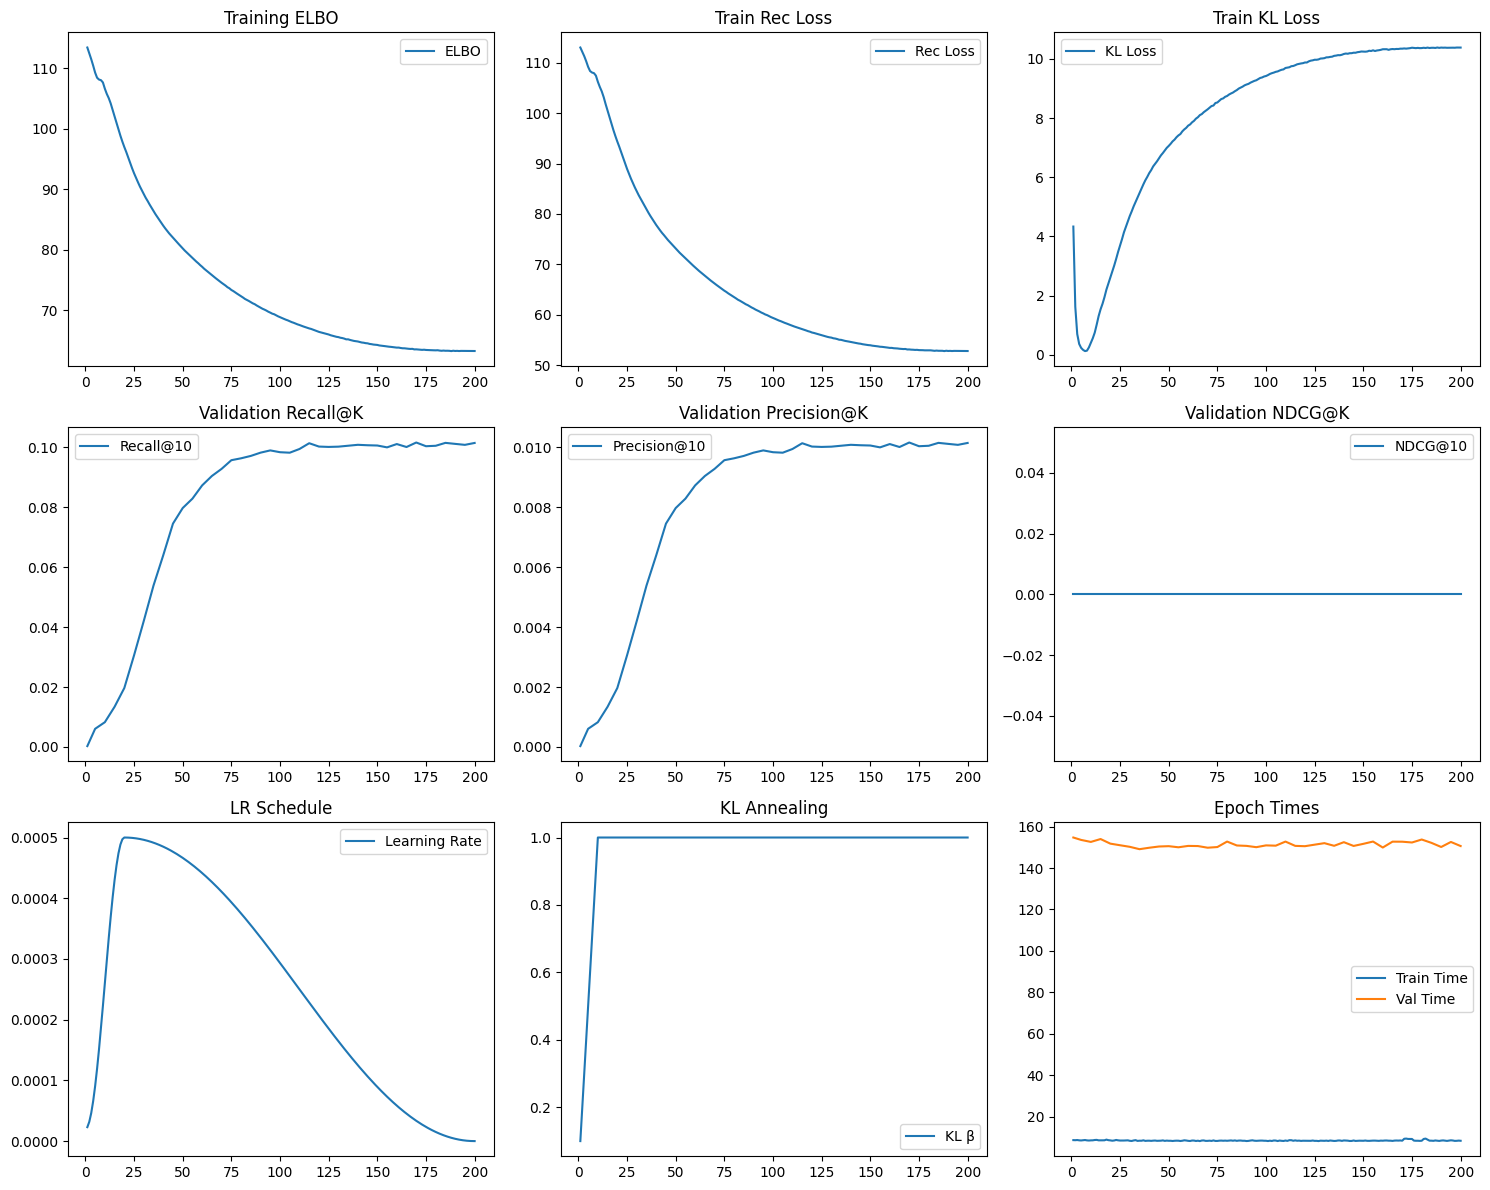

In [24]:
import os
import time
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
from scipy.sparse import csr_matrix

# CONFIGURATION (HYPERPARAMETERS)
K = 10
TRAIN_BATCH = 1024
VAL_BATCH = 4096
NUM_WORKERS = 8
EPOCHS = 200
PATIENCE = 20
ANNEAL = 10
VALIDATE_EVERY = 5
MAX_LR = 5e-4
DRIVE_DIR = "/content/drive/MyDrive/vae_project"
MODEL_PATH = os.path.join(DRIVE_DIR, 'best_vae.pth')
if not os.path.isdir(DRIVE_DIR): os.makedirs(DRIVE_DIR)

# 1) LOAD & PREP DATA
print("Loading review data…")
reviews = load_reviews(os.path.join(DRIVE_DIR, "Kindle_Store_5.json"))
user_reviews = create_review_dict(reviews)
x_real, ratings_matrix, user2id, item2id = create_user_item_matrices(user_reviews, {})
num_users, num_items = x_real.shape
print(f"Users: {num_users}, Items: {num_items}, Interactions: {int((x_real>0).sum())}")
del reviews, user_reviews
gc.collect()

# 2) LEAVE-ONE-OUT SPLITS
train_real = x_real.copy()
train_mask = (train_real > 0)
test_pairs, val_pairs = [], []
for u in range(num_users):
    pos = np.flatnonzero(train_mask[u])
    pos = [i for i in pos if ratings_matrix[u, i] >= 3]
    if not pos: continue
    ti = np.random.choice(pos)
    pos.remove(ti)
    train_real[u, ti] = 0
    train_mask[u, ti] = False
    test_pairs.append((u, ti))
    if not pos: continue
    vi = np.random.choice(pos)
    train_real[u, vi] = 0
    train_mask[u, vi] = False
    val_pairs.append((u, vi))
print(f"Test hold-outs: {len(test_pairs)}, Val hold-outs: {len(val_pairs)}")
del x_real
gc.collect()

# 3) SPARSE REPRESENTATION
train_csr = csr_matrix(train_real, dtype=np.float32)
mask_csr  = csr_matrix(train_mask.astype(np.int8), dtype=np.int8)
del train_real, train_mask
gc.collect()

# 4) DATASET & DATALOADER
class InteractionDataset(torch.utils.data.Dataset):
    def __init__(self, csr_mat):
        self.csr = csr_mat
        self.n   = csr_mat.shape[0]
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        row = self.csr.getrow(idx).toarray().ravel().astype(np.float32)
        return torch.from_numpy(row)

train_dataset = InteractionDataset(train_csr)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print(f"Train batches: {len(train_loader)}")

class ValDataset(torch.utils.data.Dataset):
    def __init__(self, csr_mat, mask_mat, pairs):
        self.csr   = csr_mat
        self.mask  = mask_mat
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        u, held = self.pairs[idx]
        row  = self.csr.getrow(u).toarray().ravel().astype(np.float32)
        mask = self.mask.getrow(u).toarray().ravel().astype(bool)
        return torch.from_numpy(row), mask, held

val_dataset = ValDataset(train_csr, mask_csr, val_pairs)
val_loader  = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=VAL_BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# 5) MODEL & OPTIMIZER & SCHEDULER & AMP
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
model     = VAE(num_items=num_items, hidden_dim1=400, hidden_dim2=200, latent_dim=50).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=1e-5)
scheduler = OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    total_steps=EPOCHS * len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)
scaler    = torch.amp.GradScaler()

# 6) HELPER FOR NDCG
def ndcg_at_k(scores, G, k=K):
    topk = np.argsort(scores)[-k:][::-1]
    dcg = sum(1.0/np.log2(i+2) for i,item in enumerate(topk) if item in G)
    idcg= sum(1.0/np.log2(i+2) for i in range(min(len(G),k)))
    return dcg/idcg if idcg>0 else 0.0

# 7) TRAIN & VALIDATE
history = {
    'epoch':       [],
    'train_elbo':  [],
    'train_rec':   [],
    'train_kl':    [],
    'val_rec':     [],
    'val_prec':    [],
    'val_ndcg':    [],
    'beta':        [],
    'lr':          [],
    'time_train':  [],
    'time_val':    []
}
best_val, wait = 0.0, 0
validation_epochs = []

for ep in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    s_elbo, s_rec, s_kl = 0.0, 0.0, 0.0
    beta = min(1.0, 0.1 + 0.9*(ep-1)/(ANNEAL-1))
    history['beta'].append(beta)

    for xb in train_loader:
        xb = xb.to(device).half()
        xb_no = xb.masked_fill(torch.rand_like(xb)<0.20, 0.0)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            logits, mu, logvar = model(xb_no)
            logp = F.log_softmax(logits,dim=1)
            rec  = -(xb * logp).sum()
            kl   = -0.5*(1 + logvar - mu.pow(2) - logvar.exp()).sum()
            loss = rec + beta * kl
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        s_elbo += loss.item()
        s_rec  += rec.item()
        s_kl   += kl.item()

    dt_train = time.time() - t0
    lr_val   = optimizer.param_groups[0]['lr']

    history['epoch'].append(ep)
    history['train_elbo'].append(s_elbo/num_users)
    history['train_rec'].append(s_rec/len(train_loader.dataset))
    history['train_kl'].append(s_kl/len(train_loader.dataset))
    history['lr'].append(lr_val)
    history['time_train'].append(dt_train)

    if ep == 1 or ep % VALIDATE_EVERY == 0:
        validation_epochs.append(ep)
        t1 = time.time()
        rr, pr, nd, cnt = 0, 0.0, 0.0, 0
        model.eval()
        with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
            for rows, masks, held in val_loader:
                rows  = rows.to(device).half()
                logits, _, _ = model(rows)
                scores = logits.cpu().float().numpy()
                for i, h in enumerate(held):
                    sc = scores[i]
                    sc[masks[i]] = -np.inf
                    hit = int(h in np.argpartition(sc, -K)[-K:])
                    rr += hit
                    pr += hit/float(K)
                    nd += ndcg_at_k(sc, {h})
                    cnt += 1
        dt_val = time.time() - t1
        val_rec  = rr/float(cnt)
        val_prec = pr/float(cnt)
        val_ndcg = nd/float(cnt)
        history['val_rec'].append(val_rec)
        history['val_prec'].append(val_prec)
        history['val_ndcg'].append(val_ndcg)
        history['time_val'].append(dt_val)
        print(f"Ep{ep}/{EPOCHS} | ELBO={history['train_elbo'][-1]:.3f} | RecLoss={history['train_rec'][-1]:.3f} | KLLoss={history['train_kl'][-1]:.3f} | Train {dt_train:.1f}s | Val {dt_val:.1f}s | Recall@{K}={val_rec:.6f} | Prec@{K}={val_prec:.6f}")
        if val_rec > best_val:
            best_val, wait = val_rec, 0
            torch.save(model.state_dict(), MODEL_PATH)
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Early stopping at epoch {ep}")
                break
    else:
        print(f"Ep{ep}/{EPOCHS} | ELBO={history['train_elbo'][-1]:.3f} | Train {dt_train:.1f}s")

# 8) TEST
model.load_state_dict(torch.load(MODEL_PATH))
rr, pr, nd, cnt = 0, 0.0, 0.0, 0
model.eval()
with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
    for (u, ti) in test_pairs:
        row  = train_csr.getrow(u).toarray().ravel().astype(np.float32)
        x_row = torch.from_numpy(row).to(device).half().unsqueeze(0)
        logits, _, _ = model(x_row)
        sc = logits.squeeze(0).cpu().numpy()
        sc[mask_csr.getrow(u).toarray().ravel().astype(bool)] = -np.inf
        hit = int(ti in np.argpartition(sc, -K)[-K:])
        rr += hit
        pr += hit/float(K)
        nd += ndcg_at_k(sc, {ti})
        cnt += 1
print(f"Test Recall@{K}={rr/float(cnt):.6f} | Prec@{K}={pr/float(cnt):.6f} | NDCG@{K}={nd/float(cnt):.6f}")

# 9) SAVE & PLOT
while len(history['val_rec']) < len(history['epoch']):
    history['val_rec'].append(None)
    history['val_prec'].append(None)
    history['val_ndcg'].append(None)
    history['time_val'].append(None)
metrics_df = pd.DataFrame(history)
metrics_df.to_csv(os.path.join(DRIVE_DIR,'metrics_history.csv'), index=False)

eps = history['epoch']
plt.figure(figsize=(15,12))
# first row: train metrics
plt.subplot(3,3,1); plt.plot(eps, history['train_elbo'], label='ELBO'); plt.title('Training ELBO'); plt.legend()
plt.subplot(3,3,2); plt.plot(eps, history['train_rec'], label='Rec Loss'); plt.title('Train Rec Loss'); plt.legend()
plt.subplot(3,3,3); plt.plot(eps, history['train_kl'],  label='KL Loss');  plt.title('Train KL Loss');  plt.legend()
# second row: validation metrics
plt.subplot(3,3,4); plt.plot(validation_epochs, history['val_rec'][:len(validation_epochs)],  label=f'Recall@{K}'); plt.title('Validation Recall@K'); plt.legend()
plt.subplot(3,3,5); plt.plot(validation_epochs, history['val_prec'][:len(validation_epochs)], label=f'Precision@{K}'); plt.title('Validation Precision@K'); plt.legend()
# third row: schedule & timing
plt.subplot(3,3,7); plt.plot(eps, history['lr'],  label='Learning Rate'); plt.title('LR Schedule'); plt.legend()
plt.subplot(3,3,8); plt.plot(eps, history['beta'],label='KL β');            plt.title('KL Annealing'); plt.legend()
plt.subplot(3,3,9); plt.plot(eps, history['time_train'],label='Train Time'); plt.plot(validation_epochs, history['time_val'][:len(validation_epochs)], label='Val Time'); plt.title('Epoch Times'); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(DRIVE_DIR,'training_plots.png'))
plt.show()
